# Mean-Reversion
This is a backtest of the following strategy:
Buy Nifty50 stock index when 3 day MA is at 5th percentile and sell when that same is at 80th percentile.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
from datetime import date
sb.set()
pd.set_option('display.max_rows', None)#to display all rows of dataframe


from matplotlib import rcParams
rcParams['figure.figsize'] = 16,12 #to set figure size

In [2]:
today = str(date.today())

In [3]:
year=int(today[:4])
year-=5
five_years_ago= str(year) + today[4:]
five_years_ago

'2016-09-16'

In [4]:
df = yf.download('^NSEI', 
                  start=five_years_ago, 
                  end=today, 
                  progress=False,
                )
df= df.drop('Open', axis=1)
df= df.drop('High', axis=1)
df= df.drop('Low', axis=1)
df= df.drop('Adj Close', axis=1)
df= df.drop('Volume', axis=1)
df

,Close
Date,
2016-09-16,8779.849609
2016-09-19,8808.400391
2016-09-20,8775.900391
2016-09-21,8777.150391
2016-09-22,8867.450195
2016-09-23,8831.549805
2016-09-26,8723.049805
2016-09-27,8706.400391
2016-09-28,8745.150391


In [5]:

df['returns'] = df['Close'].diff()
df['dummy'] = df['Close'].shift(1)
df['returns']=(df['returns']/df['dummy'])
df=df.drop('dummy',axis=1)
df

,Close,returns
Date,,
2016-09-16,8779.849609,NaN
2016-09-19,8808.400391,0.003252
2016-09-20,8775.900391,-0.003690
2016-09-21,8777.150391,0.000142
2016-09-22,8867.450195,0.010288
2016-09-23,8831.549805,-0.004049
2016-09-26,8723.049805,-0.012285
2016-09-27,8706.400391,-0.001909
2016-09-28,8745.150391,0.004451


In [6]:
df['ma']= df['Close'].rolling(21).mean()
df

,Close,returns,ma
Date,,,
2016-09-16,8779.849609,NaN,NaN
2016-09-19,8808.400391,0.003252,NaN
2016-09-20,8775.900391,-0.003690,NaN
2016-09-21,8777.150391,0.000142,NaN
2016-09-22,8867.450195,0.010288,NaN
2016-09-23,8831.549805,-0.004049,NaN
2016-09-26,8723.049805,-0.012285,NaN
2016-09-27,8706.400391,-0.001909,NaN
2016-09-28,8745.150391,0.004451,NaN


In [7]:
df['ratio']=df['Close']/df['ma']
df

,Close,returns,ma,ratio
Date,,,,
2016-09-16,8779.849609,NaN,NaN,NaN
2016-09-19,8808.400391,0.003252,NaN,NaN
2016-09-20,8775.900391,-0.003690,NaN,NaN
2016-09-21,8777.150391,0.000142,NaN,NaN
2016-09-22,8867.450195,0.010288,NaN,NaN
2016-09-23,8831.549805,-0.004049,NaN,NaN
2016-09-26,8723.049805,-0.012285,NaN,NaN
2016-09-27,8706.400391,-0.001909,NaN,NaN
2016-09-28,8745.150391,0.004451,NaN,NaN


# Getting required percentiles after testing multiple values and choosing best option

After testing multiple values, the 5th and 80th percentile seemed to capture 
most of the action

In [8]:
x=df.quantile(0.05)
p1=x['ratio'] #5th Percentile

y=df.quantile(0.8)
p2=y['ratio'] #80th Percentile

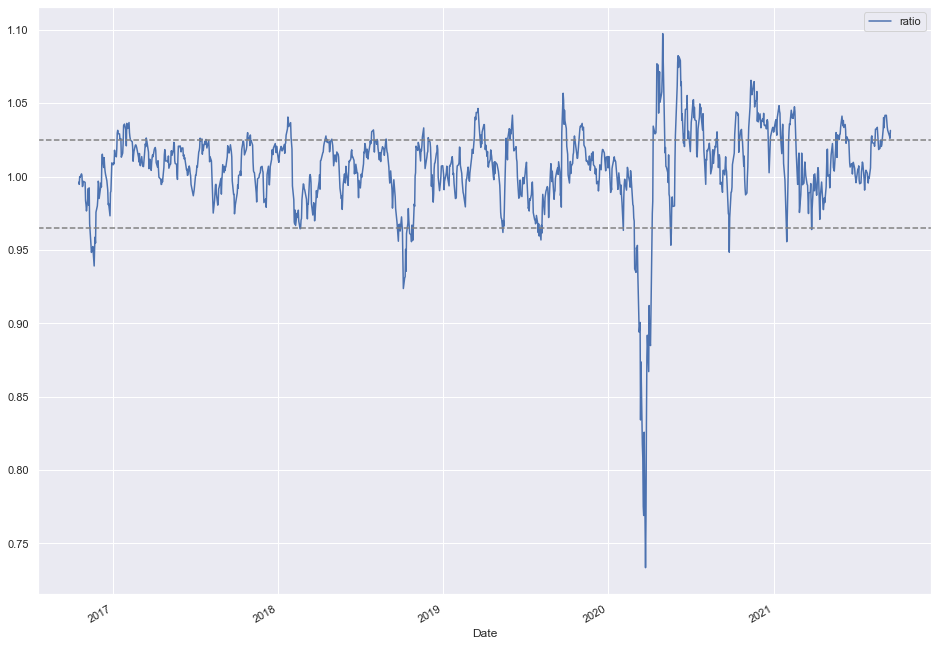

In [9]:
df['ratio'].dropna().plot(legend = True)
plt.axhline(p1, c= (.5,.5,.5), ls='--')
plt.axhline(p2, c= (.5,.5,.5), ls='--')

In [10]:
short = p2
long = p1
df['position'] = np.where(df.ratio > short,-1, np.nan)
df['position'] = np.where(df.ratio < long, 1, df['position'])
df['position'] = df['position'].ffill()

In [11]:
df

,Close,returns,ma,ratio,position
Date,,,,,
2016-09-16,8779.849609,NaN,NaN,NaN,NaN
2016-09-19,8808.400391,0.003252,NaN,NaN,NaN
2016-09-20,8775.900391,-0.003690,NaN,NaN,NaN
2016-09-21,8777.150391,0.000142,NaN,NaN,NaN
2016-09-22,8867.450195,0.010288,NaN,NaN,NaN
2016-09-23,8831.549805,-0.004049,NaN,NaN,NaN
2016-09-26,8723.049805,-0.012285,NaN,NaN,NaN
2016-09-27,8706.400391,-0.001909,NaN,NaN,NaN
2016-09-28,8745.150391,0.004451,NaN,NaN,NaN


<AxesSubplot:xlabel='Date'>

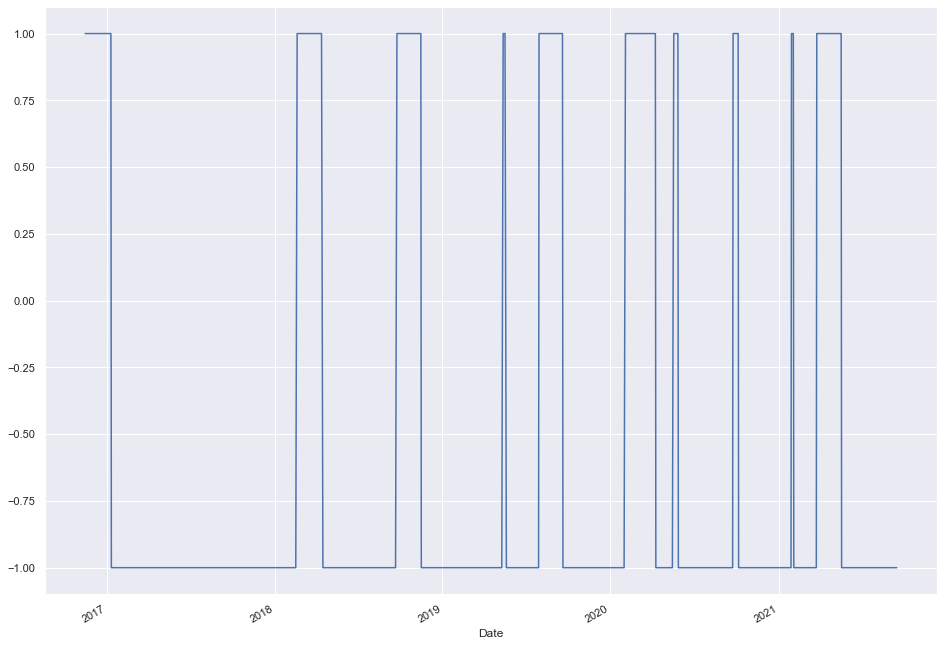

In [12]:
df.position.plot()

In [13]:
df['strat_return'] = df['returns'] * df['position'].shift(1)
df

,Close,returns,ma,ratio,position,strat_return
Date,,,,,,
2016-09-16,8779.849609,NaN,NaN,NaN,NaN,NaN
2016-09-19,8808.400391,0.003252,NaN,NaN,NaN,NaN
2016-09-20,8775.900391,-0.003690,NaN,NaN,NaN,NaN
2016-09-21,8777.150391,0.000142,NaN,NaN,NaN,NaN
2016-09-22,8867.450195,0.010288,NaN,NaN,NaN,NaN
2016-09-23,8831.549805,-0.004049,NaN,NaN,NaN,NaN
2016-09-26,8723.049805,-0.012285,NaN,NaN,NaN,NaN
2016-09-27,8706.400391,-0.001909,NaN,NaN,NaN,NaN
2016-09-28,8745.150391,0.004451,NaN,NaN,NaN,NaN


In [14]:
Close=df['Close']
strat_return=df['strat_return']
currentValue=10
loc=-1
for i in range(0,len(strat_return),1):
    if(np.isnan(strat_return[i])):
        continue
    
    currentValue=Close[i-1]
    loc=i
    break

currentValue

8108.4501953125

In [15]:
arr=[]
for i in strat_return:
    if(np.isnan(i)):
        arr.append(np.nan)
        continue
    currentValue=currentValue + (currentValue*i)
    arr.append(currentValue)

df['returns(strategy)']=arr
df

,Close,returns,ma,ratio,position,strat_return,returns(strategy)
Date,,,,,,,
2016-09-16,8779.849609,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-19,8808.400391,0.003252,NaN,NaN,NaN,NaN,NaN
2016-09-20,8775.900391,-0.003690,NaN,NaN,NaN,NaN,NaN
2016-09-21,8777.150391,0.000142,NaN,NaN,NaN,NaN,NaN
2016-09-22,8867.450195,0.010288,NaN,NaN,NaN,NaN,NaN
2016-09-23,8831.549805,-0.004049,NaN,NaN,NaN,NaN,NaN
2016-09-26,8723.049805,-0.012285,NaN,NaN,NaN,NaN,NaN
2016-09-27,8706.400391,-0.001909,NaN,NaN,NaN,NaN,NaN
2016-09-28,8745.150391,0.004451,NaN,NaN,NaN,NaN,NaN


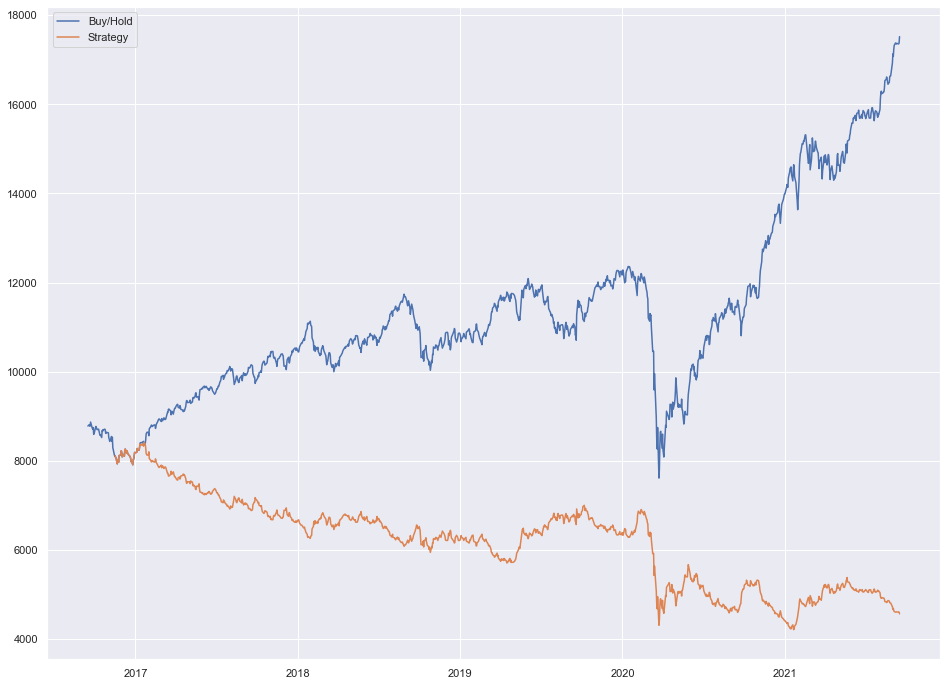

In [16]:
plt.plot(df['Close'], label='Buy/Hold')
plt.plot(df['returns(strategy)'], label='Strategy')
plt.legend();

In [17]:
buyhold=(Close[len(Close)-1]-Close[0]) / Close[0]
print("Buy/Hold return : ", buyhold*100 , "%")

Close1=df['returns(strategy)']

strat=(Close1[len(Close1)-1]-Close1[loc]) / Close1[loc]
print("Strategy return : ", strat*100 , "%")

Buy/Hold return :  99.54156390153857 %
Strategy return :  -43.7465864262671 %


In [18]:
#Strategy fail